<a href="https://colab.research.google.com/github/ashinkrishnan/Volumetric-Medical-Image-Segmentation-using-2D-U-NET/blob/main/model_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prediction using T1w_MRI_test data

In [1]:

from tensorflow.keras.models import load_model

In [2]:
#loadig the model from HDF file
model = load_model('/content/drive/MyDrive/UNET-MRI-brain.h5')

In [3]:
model.summary()

Model: "UNET-L2-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 192, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 192, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 96, 32)  0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [4]:
#model.get_weights()

In [5]:
model.optimizer

In [27]:
from tensorflow.keras.models import load_model
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [7]:
#constants for normalization
HOUNSFIELD_MIN = 0
HOUNSFIELD_MAX = 2900 #obtained by inspecting the target data
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

#for slicing 
SLICE_X = True
SLICE_Y = True
SLICE_Z = False

#std. dimension by which model trained
IMAGE_HEIGHT = 256
IMAGE_WIDTH  = 192 
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [61]:
#loading the test image 
targetImagePath = '/content/drive/MyDrive/T1w_MRI_test_data/T1Img/sub-03/T1w MRI.nii'
img = nib.load(targetImagePath).get_fdata()
np.min(img),np.max(img),img.shape,type(img)

(0.0, 2877.0, (256, 256, 176), numpy.memmap)

In [9]:
#function for normalization
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN)/HOUNSFIELD_RANGE

In [10]:
targetImagePath = '/content/drive/MyDrive/T1w_MRI_test_data/T1Img/sub-03/T1w MRI.nii'
imgTargetNii = nib.load(targetImagePath)
imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())

In [23]:
# prediction of single slice using T1w_MRI test data:

In [12]:
#function for resizing the image
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [13]:
sliceIndex = 128

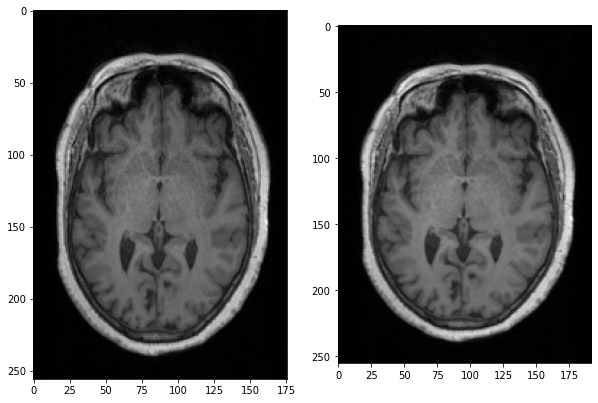

((256, 176), (256, 192))

In [14]:
# show input image slice[original and resized]
plt.figure(figsize=(10,10))
imgSlice = imgTarget[:,sliceIndex,:]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')#original
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')#rescaled
plt.show()
imgSlice.shape, imgSliceScaled.shape

In [15]:
#model = load_model('/content/drive/MyDrive/UNET-MRI-brain.h5')

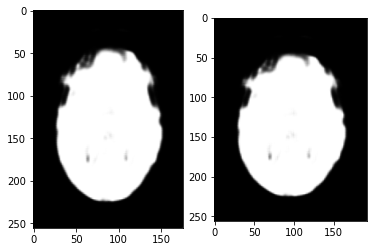

((256, 176), (256, 192))

In [16]:
#predict with UNet model[showing original and resized]
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]
maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape


Predicting a full Volume

In [51]:
#Predicting a full volume
def predictVolume(inImg,to_Binary=True):
  (xMax,yMax,zMax) = inImg.shape

  #place holder
  outImgX = np.zeros((xMax,yMax,zMax))
  outImgY = np.zeros((xMax,yMax,zMax))
  outImgZ = np.zeros((xMax,yMax,zMax))

  cnt = 0.0
  if SLICE_X:
    cnt += 1.0
    for i in range(xMax):
        img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
        tmp = model.predict(img)[0,:,:,0]
        outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
  if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
  if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
  outImg = (outImgX + outImgY + outImgZ)/cnt
  if(to_Binary):#since u net gives probabilistic o/p,it needs to be converted into binary
      outImg[outImg>0.4] = 1.0
      outImg[outImg<=0.4] = 0.0
  return outImg



In [52]:
predImg = predictVolume(imgTarget)

In [53]:
predImg.shape,imgTarget.shape

((256, 256, 176), (256, 256, 176))

In [68]:
sliceIndex_test = 128

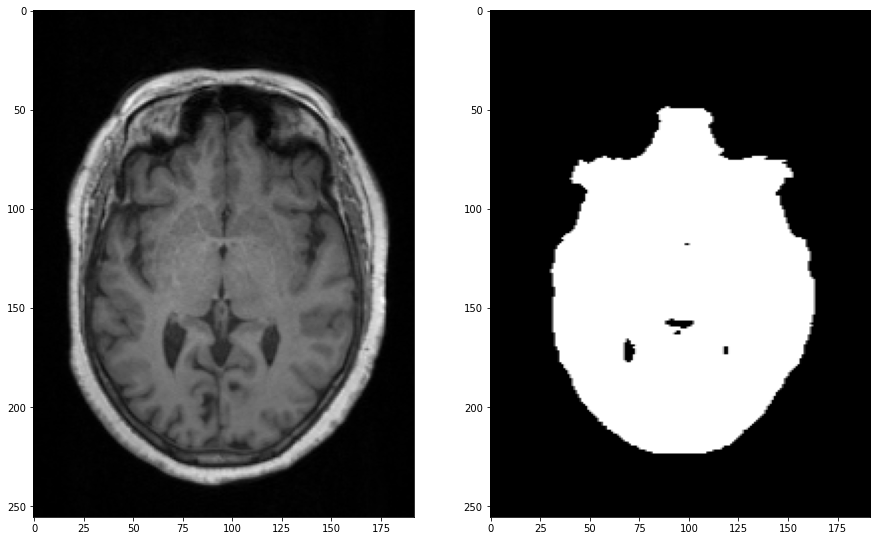

In [69]:
plt.figure(figsize=(15,15))

imgSlice = imgTarget[:,sliceIndex_test,:]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSliceScaled, cmap='gray')

maskSlice = predImg[:,sliceIndex_test,:]
imgDimX, imgDimY = maskSlice.shape
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled,cmap='gray')

In [59]:
# img_slice = predImg[:,128,:]
# plt.imshow(img_slice, cmap='gray')
# plt.show()

In [25]:
!pip install niwidgets

     |████████████████████████████████| 12.5MB 7.3MB/s 
     |████████████████████████████████| 2.9MB 32.1MB/s 
     |████████████████████████████████| 5.4MB 24.6MB/s 
     |████████████████████████████████| 3.3MB 33.1MB/s 
     |████████████████████████████████| 2.4MB 37.9MB/s 
     |████████████████████████████████| 3.4MB 29.4MB/s 
     |████████████████████████████████| 266kB 40.2MB/s 
     |████████████████████████████████| 276kB 48.6MB/s 
ERROR: nibabel 2.5.2 has requirement numpy<1.17dev,>=1.8, but you'll have numpy 1.19.5 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [37]:
!pip install scikit-learn==0.20.4

  Using cached https://files.pythonhosted.org/packages/87/6f/5863f1b27523c5d9f0ae2f3d07828ad383ceab39c79726d2ea4da7f679e7/scikit_learn-0.20.4-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [60]:
#from niwidgets import NiftiWidget